In [2]:
# Load packages

#from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
import matplotlib.ticker as mticker
from collections import Counter 
import pickle
from datetime import timedelta as delta
%matplotlib inline

In [3]:
def lonlatdistance(loc1,loc2):
    """Function to calculate distance between two lonlat points"""
    R = 6373.0
    lat1 = math.radians(loc1[1])
    lon1 = math.radians(loc1[0])
    lat2 = math.radians(loc2[1])
    lon2 = math.radians(loc2[0])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [4]:
def getclosest_ij(lats,lons,latpt,lonpt):
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_lat = (lats-latpt)**2          # find squared distance of every point on grid
    dist_lon = (lons-lonpt)**2
    minindex_lat = dist_lat.argmin()    # 1D index of minimum dist_sq element
    minindex_lon = dist_lon.argmin()
    return minindex_lat, minindex_lon   # Get 2D index for latvals and lonvals arrays from 1D index

In [5]:
def makelandmask_moi(fieldU, fieldV, domain):
    """ Returns landmask where land = 1 and ocean = 0"""
    
    # get indices for correct domain
    dfile = Dataset(fieldU)
    lon = dfile.variables['nav_lon'][1500,:]
    lat = dfile.variables['nav_lat'][:,1100]
    ymin, xmin = getclosest_ij(lat, lon, domain[2], domain[0])
    ymax, xmax = getclosest_ij(lat, lon, domain[3], domain[1])
    lon = dfile.variables['nav_lon'][ymin+1:ymax,xmin+1:xmax]
    lat = dfile.variables['nav_lat'][ymin+1:ymax,xmin+1:xmax]
    
    # get U and V mask (specified on NEMO C-grid)
    Umask1 = dfile.variables['vozocrtx'][0,ymin+1:ymax,xmin+1:xmax]
    Umask2 = dfile.variables['vozocrtx'][0,ymin+1:ymax,xmin:xmax-1]
    dfile = Dataset(fieldV)
    Vmask1 = dfile.variables['vomecrty'][0,ymin+1:ymax,xmin+1:xmax]  
    Vmask2 = dfile.variables['vomecrty'][0,ymin:ymax-1,xmin+1:xmax]
    Umask1 = np.ma.masked_invalid(Umask1)
    Umask1 = Umask1.mask.astype('int')
    Umask2 = np.ma.masked_invalid(Umask2)
    Umask2 = Umask2.mask.astype('int')
    Vmask1 = np.ma.masked_invalid(Vmask1)
    Vmask1 = Vmask1.mask.astype('int')
    Vmask2 = np.ma.masked_invalid(Vmask2)
    Vmask2 = Vmask2.mask.astype('int')
    
    # make landmask (specified at T-point)
    landmask_map = np.zeros_like(Umask1)
    landmask_map[(Umask1 == 1) &(Umask2 == 1) & (Vmask1 == 1) & (Vmask2 == 1)] = 1
    
    # make coastline mask (specified at T-point)
    coastmask_map = np.zeros_like(landmask_map)
    for i in range(coastmask_map.shape[1]):
        for j in range(coastmask_map.shape[0]):
            if landmask_map[j,i]==1:
                coastmask_map[j-1:j+2,i-1:i+2]=1

    coastmask_map = coastmask_map + landmask_map
    coastmask_map[np.where(coastmask_map>1)]=0
    indexcells = np.where(coastmask_map>0)
    teller=1
    for i in range(len(indexcells[0][:])):
        coastmask_map[indexcells[0][i],indexcells[1][i]] = teller
        teller += 1
    
    return lon, lat, landmask_map, coastmask_map

In [6]:
def getdistance_moi(lon,lat,coastmask_map,landmask_map,coastal_lons,coastal_lats):
    """Returns map of distance to islands and mask of closest island"""

    distance_map = np.zeros(coastmask_map.shape)
    seaborder_map = np.zeros(coastmask_map.shape)
    for i in range(1,distance_map.shape[1]):
        for j in range(1,distance_map.shape[0]):        
            loc1 = [lon[j,i], lat[j,i]]
            D = (lon[j,i]-coastal_lons[:])**2 + (lat[j,i]-coastal_lats[:])**2
            index_min = np.argmin(D)
            loc2 = [coastal_lons[index_min],coastal_lats[index_min]]
            distance = lonlatdistance(loc1,loc2)
            distance_map[j,i] = distance
    
    distance_map[landmask_map==1]=0
    
    return distance_map

In [7]:
def getcoastseeding(coastmask_map):
    '''Get seeding locations along model coastline South America'''
    
    locindex = np.where(coastmask_map!=0)
    coastal_lons = lon[locindex]
    coastal_lats = lat[locindex]
    
    # clean up
    index1 = np.where((coastal_lons>-98) & (coastal_lats>17))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where((coastal_lons>-90) & (coastal_lats>15))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where((coastal_lons>-80) & (coastal_lats>9))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where((coastal_lons>-77.8) & (coastal_lats>7.5))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where((coastal_lons>-84) & (coastal_lats>9.2))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where((coastal_lons>-82.5) & (coastal_lats>8.6) & (coastal_lons<-80))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where((coastal_lons<-77) & (coastal_lats<-30))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where(coastal_lats<-46)
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan
    index1 = np.where((coastal_lons<-86) & (coastal_lons >-88) & (coastal_lats<6) & (coastal_lats>4))
    coastal_lons[index1[0][:]] = nan
    coastal_lats[index1[0][:]] = nan

    coastal_lats = coastal_lats[~numpy.isnan(coastal_lats)]
    coastal_lons = coastal_lons[~numpy.isnan(coastal_lons)]
    
    return coastal_lats, coastal_lons

In [8]:
def getobservationsseeding(fieldobs,coastal_lons, coastal_lats, total_per_release, seeding_duration):
    '''Get seeding location closest to observations'''
    
    obs = pd.read_excel(fieldobs)

    lat_obs = np.array(obs.Latitude)
    lon_obs = np.array(obs.Longitude)
    time_obs = np.array(obs.Sampling)

    # Connect observation location to closest model coastal grid cell

    lonM = []
    latM = []

    for i in range(len(lon_obs)):

        D = (lon_obs[i]-coastal_lons[:])**2 + (lat_obs[i]-coastal_lats[:])**2
        index_min = np.argmin(D)
        lonM.append(coastal_lons[index_min])
        latM.append(coastal_lats[index_min])

    # randomly displace startlocation within seeding grid cell and add time of release 
    dx = 1/15
    x_displace = (np.random.rand(total_per_release)-0.5)*dx
    y_displace = (np.random.rand(total_per_release)-0.5)*dx
    seeding = np.arange(np.timedelta64(1,'D'),np.timedelta64(seeding_duration+1,'D')) #seeding daily for 1 year 
    id_add = np.zeros(total_per_release)

    releaselon = []
    releaselat = []
    releaseID = []
    releasetime = []

    # loop per release location
    for p in range(len(lon_obs)):

        new_lats = latM[p]+y_displace
        new_lons = lonM[p]+x_displace
        new_IDs = p+id_add   

        new_lats = np.tile(new_lats,seeding_duration)
        new_lons = np.tile(new_lons,seeding_duration)
        new_IDs = np.tile(new_IDs,seeding_duration)

        seeding_time = time_obs[p] - seeding # seeding backwards in time
        seeding_time = np.repeat(seeding_time,total_per_release)

        releaselon.append(new_lons)
        releaselat.append(new_lats)
        releaseID.append(new_IDs)
        releasetime.append(seeding_time)

    releaselon = np.reshape(releaselon,-1)
    releaselat = np.reshape(releaselat,-1)
    releaseID = np.reshape(releaseID,-1)
    releasetime = np.reshape(releasetime,-1)

    #sort by release time backwards in time
    releaselon = np.flipud(releaselon[np.argsort(releasetime)])
    releaselat = np.flipud(releaselat[np.argsort(releasetime)])
    releaseID = np.flipud(releaseID[np.argsort(releasetime)])
    releasetime = np.flipud(releasetime[np.argsort(releasetime)])
        
    return releaselon, releaselat, releaseID, releasetime


In [10]:
# Get all input fields

# input
domain = [-125, -69, -57, 35]
data_path = '/Users/f103457/surfdrive/GalapagosAnalysis/'
fieldU = data_path + 'Data/modelfields/MOi/psy4v3r1-daily_U_2016-03-01.nc'
fieldV = data_path + 'Data/modelfields/MOi/psy4v3r1-daily_V_2016-03-01.nc'
fieldobs = data_path + 'Analysis/Projects/Model_epibionts/particle_simulation/input/Data_Observations.xls'

# seeding characteristics
total_per_release = 630 # seed randomly close to observation location
seeding_duration = 30 # seed daily up until observation measurement

# get all fields of interest
lon, lat, landmask_map, coastmask_map = makelandmask_moi(fieldU, fieldV, domain)
lats_coast, lons_coast = getcoastseeding(coastmask_map)
distance_map = getdistance_moi(lon,lat,coastmask_map,landmask_map,lons_coast,lats_coast)
releaselon, releaselat, releaseID, releasetime = getobservationsseeding(fieldobs,lons_coast,lats_coast,total_per_release, seeding_duration)


/var/folders/8h/ddqcss_n7hdgcs50lm1s7z_c0000gn/T/ipykernel_8616/3124065963.py:6: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  lon = dfile.variables['nav_lon'][1500,:]
/var/folders/8h/ddqcss_n7hdgcs50lm1s7z_c0000gn/T/ipykernel_8616/3124065963.py:6: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  lon = dfile.variables['nav_lon'][1500,:]
/var/folders/8h/ddqcss_n7hdgcs50lm1s7z_c0000gn/T/ipykernel_8616/3124065963.py:10: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  lon = dfile.variables['nav_lon'][ymin+1:ymax,xmin+1:xmax]
/var/folders/8h/ddqcss_n7hdgcs50lm1s7z_c0000gn/T/ipykernel_8616/3124065963.py:10: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  lon = dfile.variables['nav_lon'][ymin+1:ymax,xmin+1:xmax]


In [11]:
# Save all data

maps = {}
maps['landmask'] = landmask_map
maps['coastcells'] = coastmask_map
maps['lon'] = lon.data
maps['lat'] = lat.data
maps['distance'] = distance_map
maps['lonSA'] = lons_coast
maps['latSA'] = lats_coast
maps['releaselon'] = releaselon
maps['releaselat'] = releaselat
maps['releaseID'] = releaseID
maps['releasetime'] = releasetime
file = open('input/inputfiles_epibionts', 'wb')
pickle.dump(maps, file)
file.close()


(831600,)


/var/folders/8h/ddqcss_n7hdgcs50lm1s7z_c0000gn/T/ipykernel_8616/1192964463.py:22: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  im=axs.pcolor(lon,lat,distance_map,cmap='twilight',vmin=0, vmax=3000, shading='auto')


Text(0, 0.5, 'distance (km)')

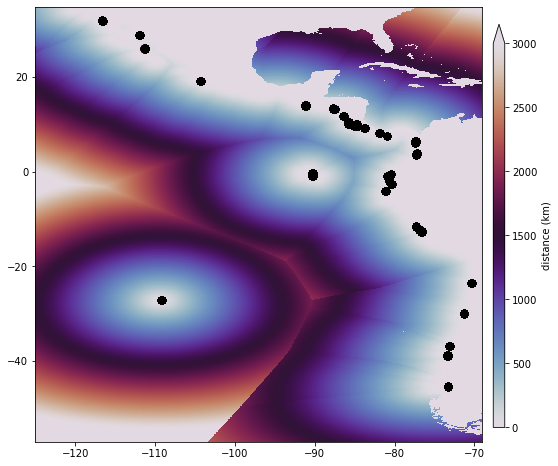

In [9]:
# Check release locations

file = open('input/inputfiles_epibionts', 'rb')
inputfiles = pickle.load(file)
file.close()

file = open('input/inputfiles_epibionts_30d', 'rb')
inputfile_release = pickle.load(file)
file.close()

distance_map = inputfiles['distance']
lon = inputfiles['lon']
lat = inputfiles['lat']

lons = inputfile_release['releaselon']
lats = inputfile_release['releaselat']

print(lons.shape)

figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)
im=axs.pcolor(lon,lat,distance_map,cmap='twilight',vmin=0, vmax=3000, shading='auto')
axs.scatter(lons, lats, s=40, c='k')
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max')
cbar.ax.set_ylabel('distance (km)')
